# Industry 4.0 의 중심, BigData

<div align='right'><font size=2 color='gray'>Data Processing Based Python @ <font color='blue'><a href='https://www.facebook.com/jskim.kr'>FB / jskim.kr</a></font>, [김진수](bigpycraft@gmail.com)</font></div>
<hr>

## 부품가격 조회사이트에서 필요한 정보 파싱
- <a href='http://221.143.43.214/'>스카니아 부품가격 조회</a>
- 브랜드별 SCANIA, HINO 검색정보 리스트 가져오기
- 컬럼정보 : 적용일, 순번, 브랜드, 부품그룹, 부품번호, 부품명(한글), 부품명(영문), 가격(VAT별도)
<hr>
- <a href='http://parts.volvotruck.kr/main.html'>볼보트럭 부품가격 조회</a>
- 브랜드별 볼보트럭, 유디트럭 검색정보 리스트 가져오기
- 컬럼정보 : 브랜드, 부품그룹, 부품번호, 부품명(한글), 부품명(영문), 가격, 적용일


## VOLVO TRUCK KOREA 부품가격정보 크롤링

In [1]:
# import library for collecting of data
from selenium import webdriver as wd
from bs4 import BeautifulSoup as bs

from selenium.webdriver.common.by import By

# for waiting
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from IPython.display import Image

import numpy as np
import pandas as pd
import platform
import time
import sys
import csv
import re

### <font color='brown'>Step1. Collecting Data 건수 미리 알아보기</font>

In [2]:
# load driver
if platform.system() == 'Darwin':    # MacOS
    driver = wd.Chrome(executable_path='./driver/chromedriver')      
elif platform.system() == 'Windows': # Windows
    driver = wd.Chrome(executable_path='./driver/chromedriver.exe')    
else:
    print("It's unknown system. Hangul fonts are not supported!")

In [3]:
target_url = 'http://parts.volvotruck.kr/main.html'
target_url = 'http://parts.volvotruck.kr/main.html?schWord=&schBrand={}&schGroup1=&schGroup2=&schCarType=&page={}'
schBrand = '1'      # 1:볼보트럭, 2:유디트럭  
schPage  = 10

In [4]:
# 사이트 접속 (get) : 셀레니움이 하는 일은 사림이 하는일과 최대한 유사하게 동작하도록 작업
# time.sleep(2)
driver.get(target_url.format(schBrand, schPage))

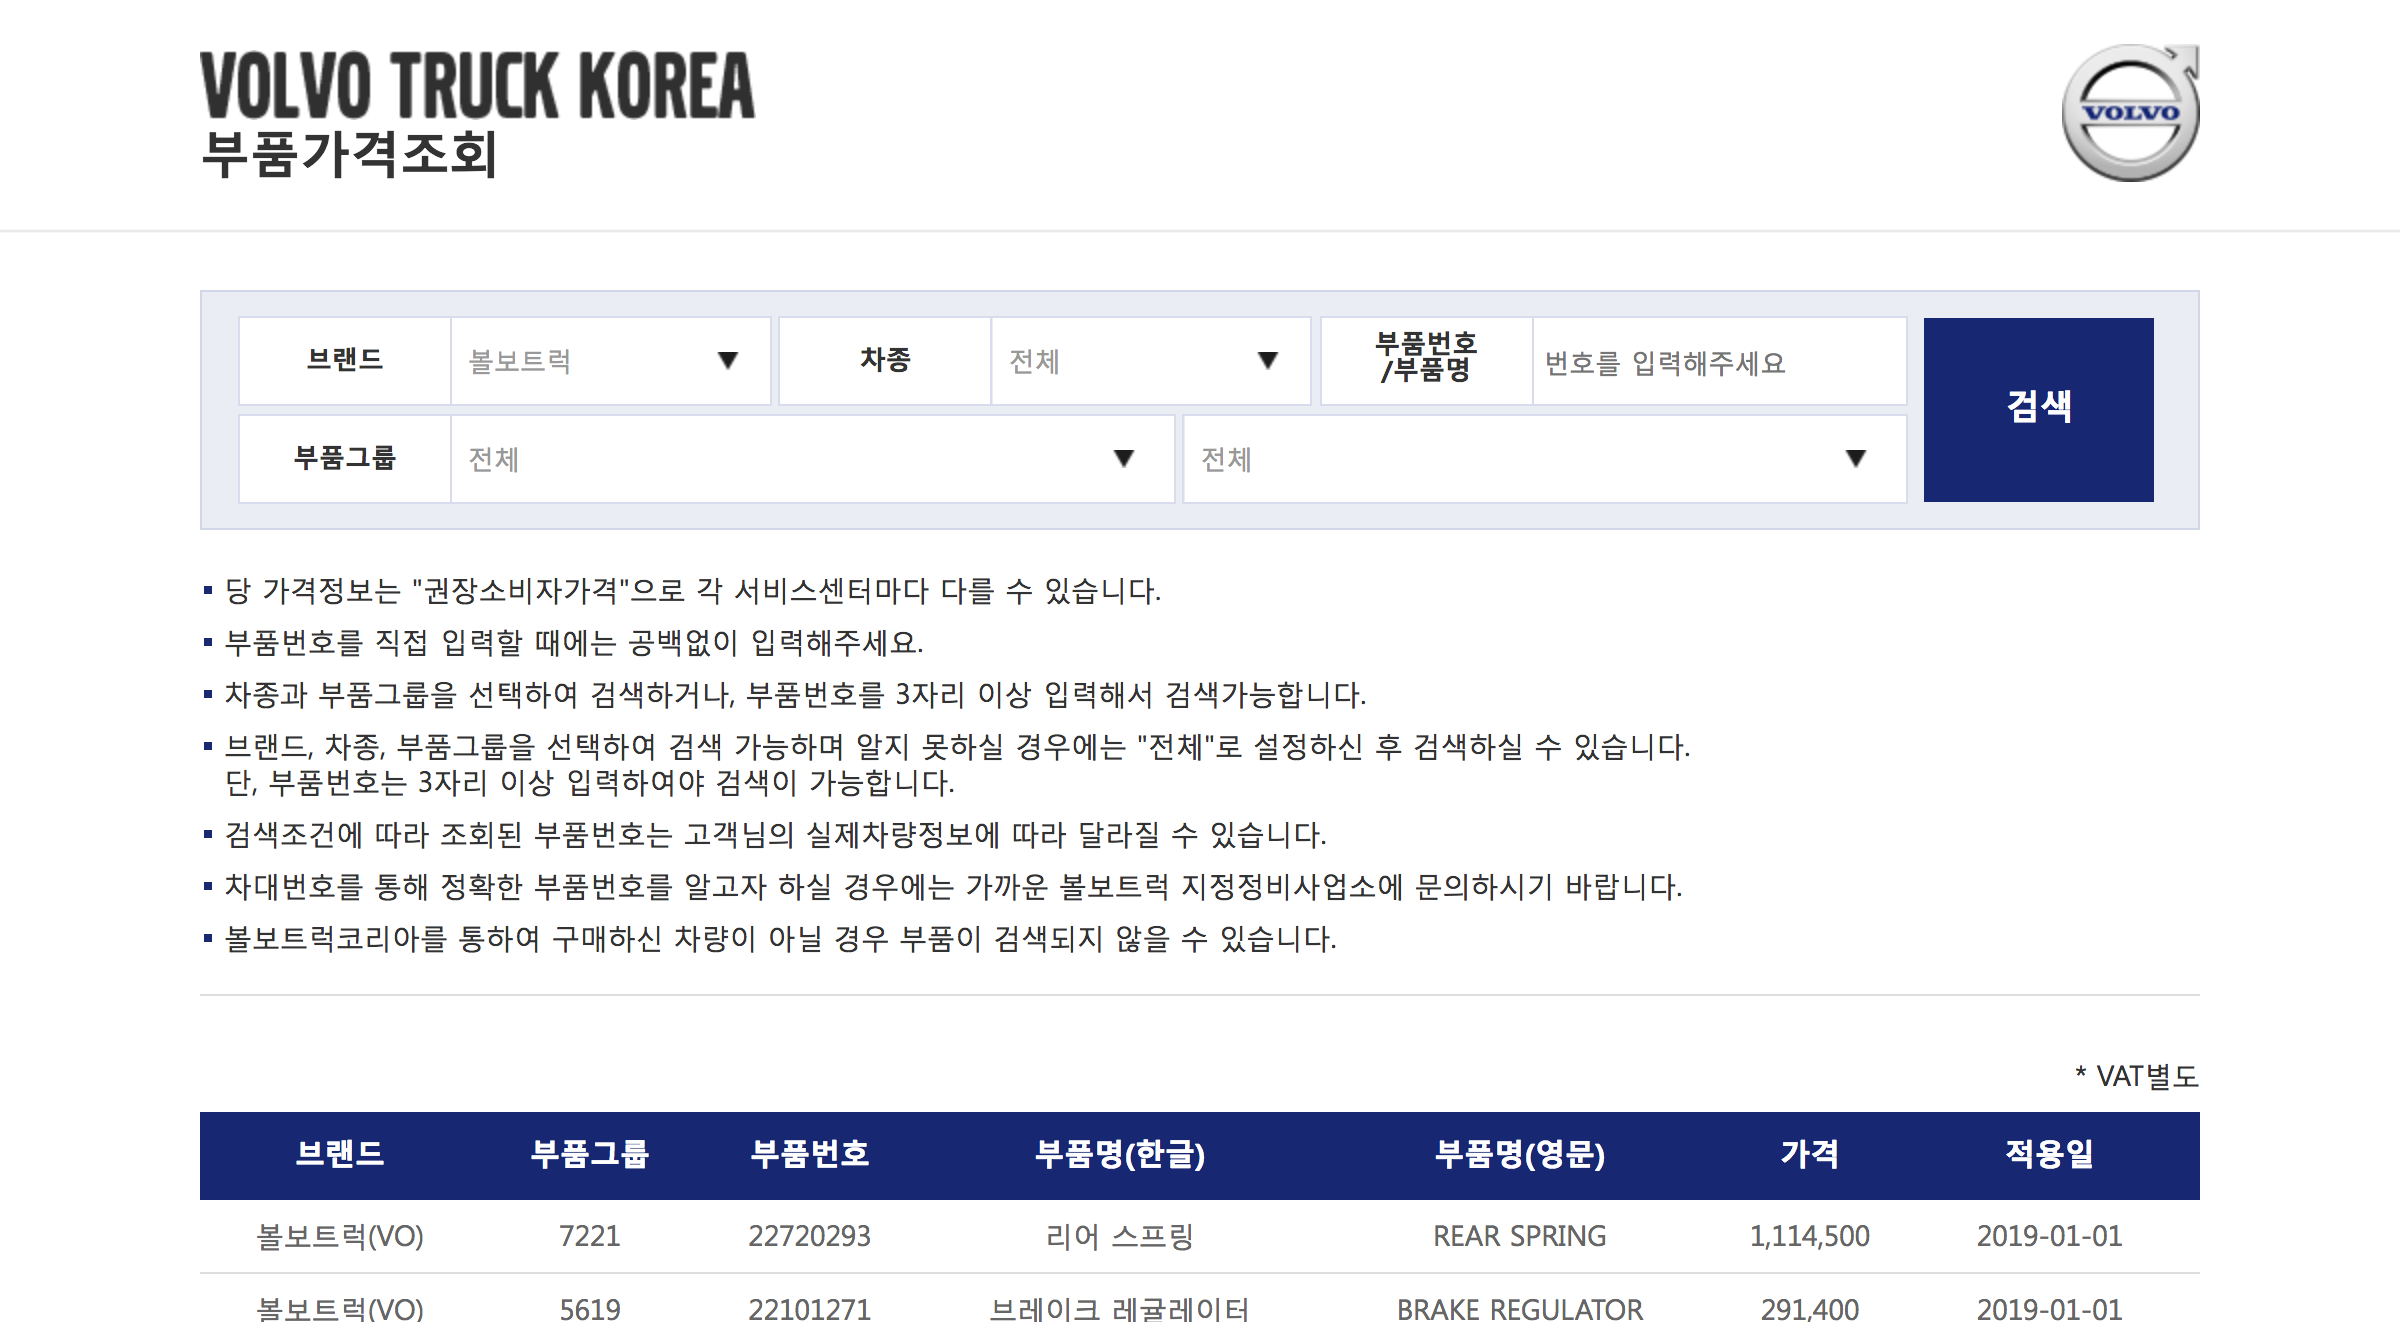

In [5]:
capture_img = './images/volvotruck_site.png'
driver.save_screenshot(capture_img)
Image(capture_img)

In [6]:
# read source code
html = driver.page_source
soup = bs(html, "lxml")
soup.title

<title>볼보 부품관리조회</title>

In [7]:
tmp = soup.find('a', 'first_back')
lastlink = tmp['href']
lastlink

'/main.html?schWord=&schBrand=1&schGroup1=&schGroup2=&schCarType=&page=18661'

In [8]:
lastpage = re.search('page=\d+', lastlink)

if lastpage is None:
    lastpage = 1
else:
    lastpage = lastpage.group()[5:]
    lastpage = int(lastpage)
    
lastpage

18661

In [17]:
# schBrand = '1'      # 1:볼보트럭, 2:유디트럭  

def get_lastpage(driver, schBrand='1'):       
    '''
    Get a lastpage by brand
    Args:  
        schBrand : str, value of brand code    
                   cf. 1:볼보트럭, 2:유디트럭  
    Returns:
        last_page  : int, page number
    '''
    last_page = 0

    target_url = 'http://parts.volvotruck.kr/main.html?schWord=&schBrand={}&schGroup1=&schGroup2=&schCarType=&page={}'
    # schBrand = schBrand      # 1:볼보트럭, 2:유디트럭  
    # schPage  = 1
    # driver.get(target_url.format(schBrand, schPage))
    driver.get(target_url.format(schBrand, 1))

    html = driver.page_source
    soup = bs(html, "lxml")
    
    
    # 마지막 네비게이션페이지 링크 확인
    tmp = soup.find('a', 'first_back')
    
    if tmp is None:
        print('데이터가 많지 않습니다.')
    else :
        lastlink = tmp['href']

        page = re.search('page=\d+', lastlink)

        if page is None:
            last_page = 1
        else:
            last_page = page.group()[5:]
            last_page = int(last_page)

        result_cnt = last_page * 10
        brand_nm = (lambda schBrand : '볼보트럭' if schBrand == '1' else '유디트럭' if schBrand == '2' else '모든트럭')(schBrand)

        print('{} 데이터수는 약 {}건이며, 마지막 페이지는 {}입니다.'.format(brand_nm, result_cnt, last_page))
    
    return last_page



In [21]:
schBrand = '1'
lastpage = get_lastpage(driver, schBrand)
lastpage

볼보트럭 데이터수는 약 186610건이며, 마지막 페이지는 18661입니다.


18661

In [66]:
# 1:볼보트럭, 2:유디트럭 
schBrand = '1'

if schBrand is '1':    
    brand_nm = '볼보트럭'
elif schBrand is '2':
    brand_nm = '유디트럭'
else:
    brand_nm = '모든트럭'
    
brand_nm

'볼보트럭'

In [61]:
schBrand = '1'
brand_nm = (lambda schBrand : '볼보트럭' if schBrand == '1' else '유디트럭' if schBrand == '2' else '모든트럭')(schBrand)
brand_nm

'볼보트럭'

### <font color='brown'>Step2. Device Info 가져오기</font>

In [26]:
target_url = 'http://parts.volvotruck.kr/main.html?schWord=&schBrand={}&schGroup1=&schGroup2=&schCarType=&page={}'
schBrand = '1'      # 1:볼보트럭, 2:유디트럭  
schPage  = 1

In [27]:
driver.get(target_url.format(schBrand, schPage))

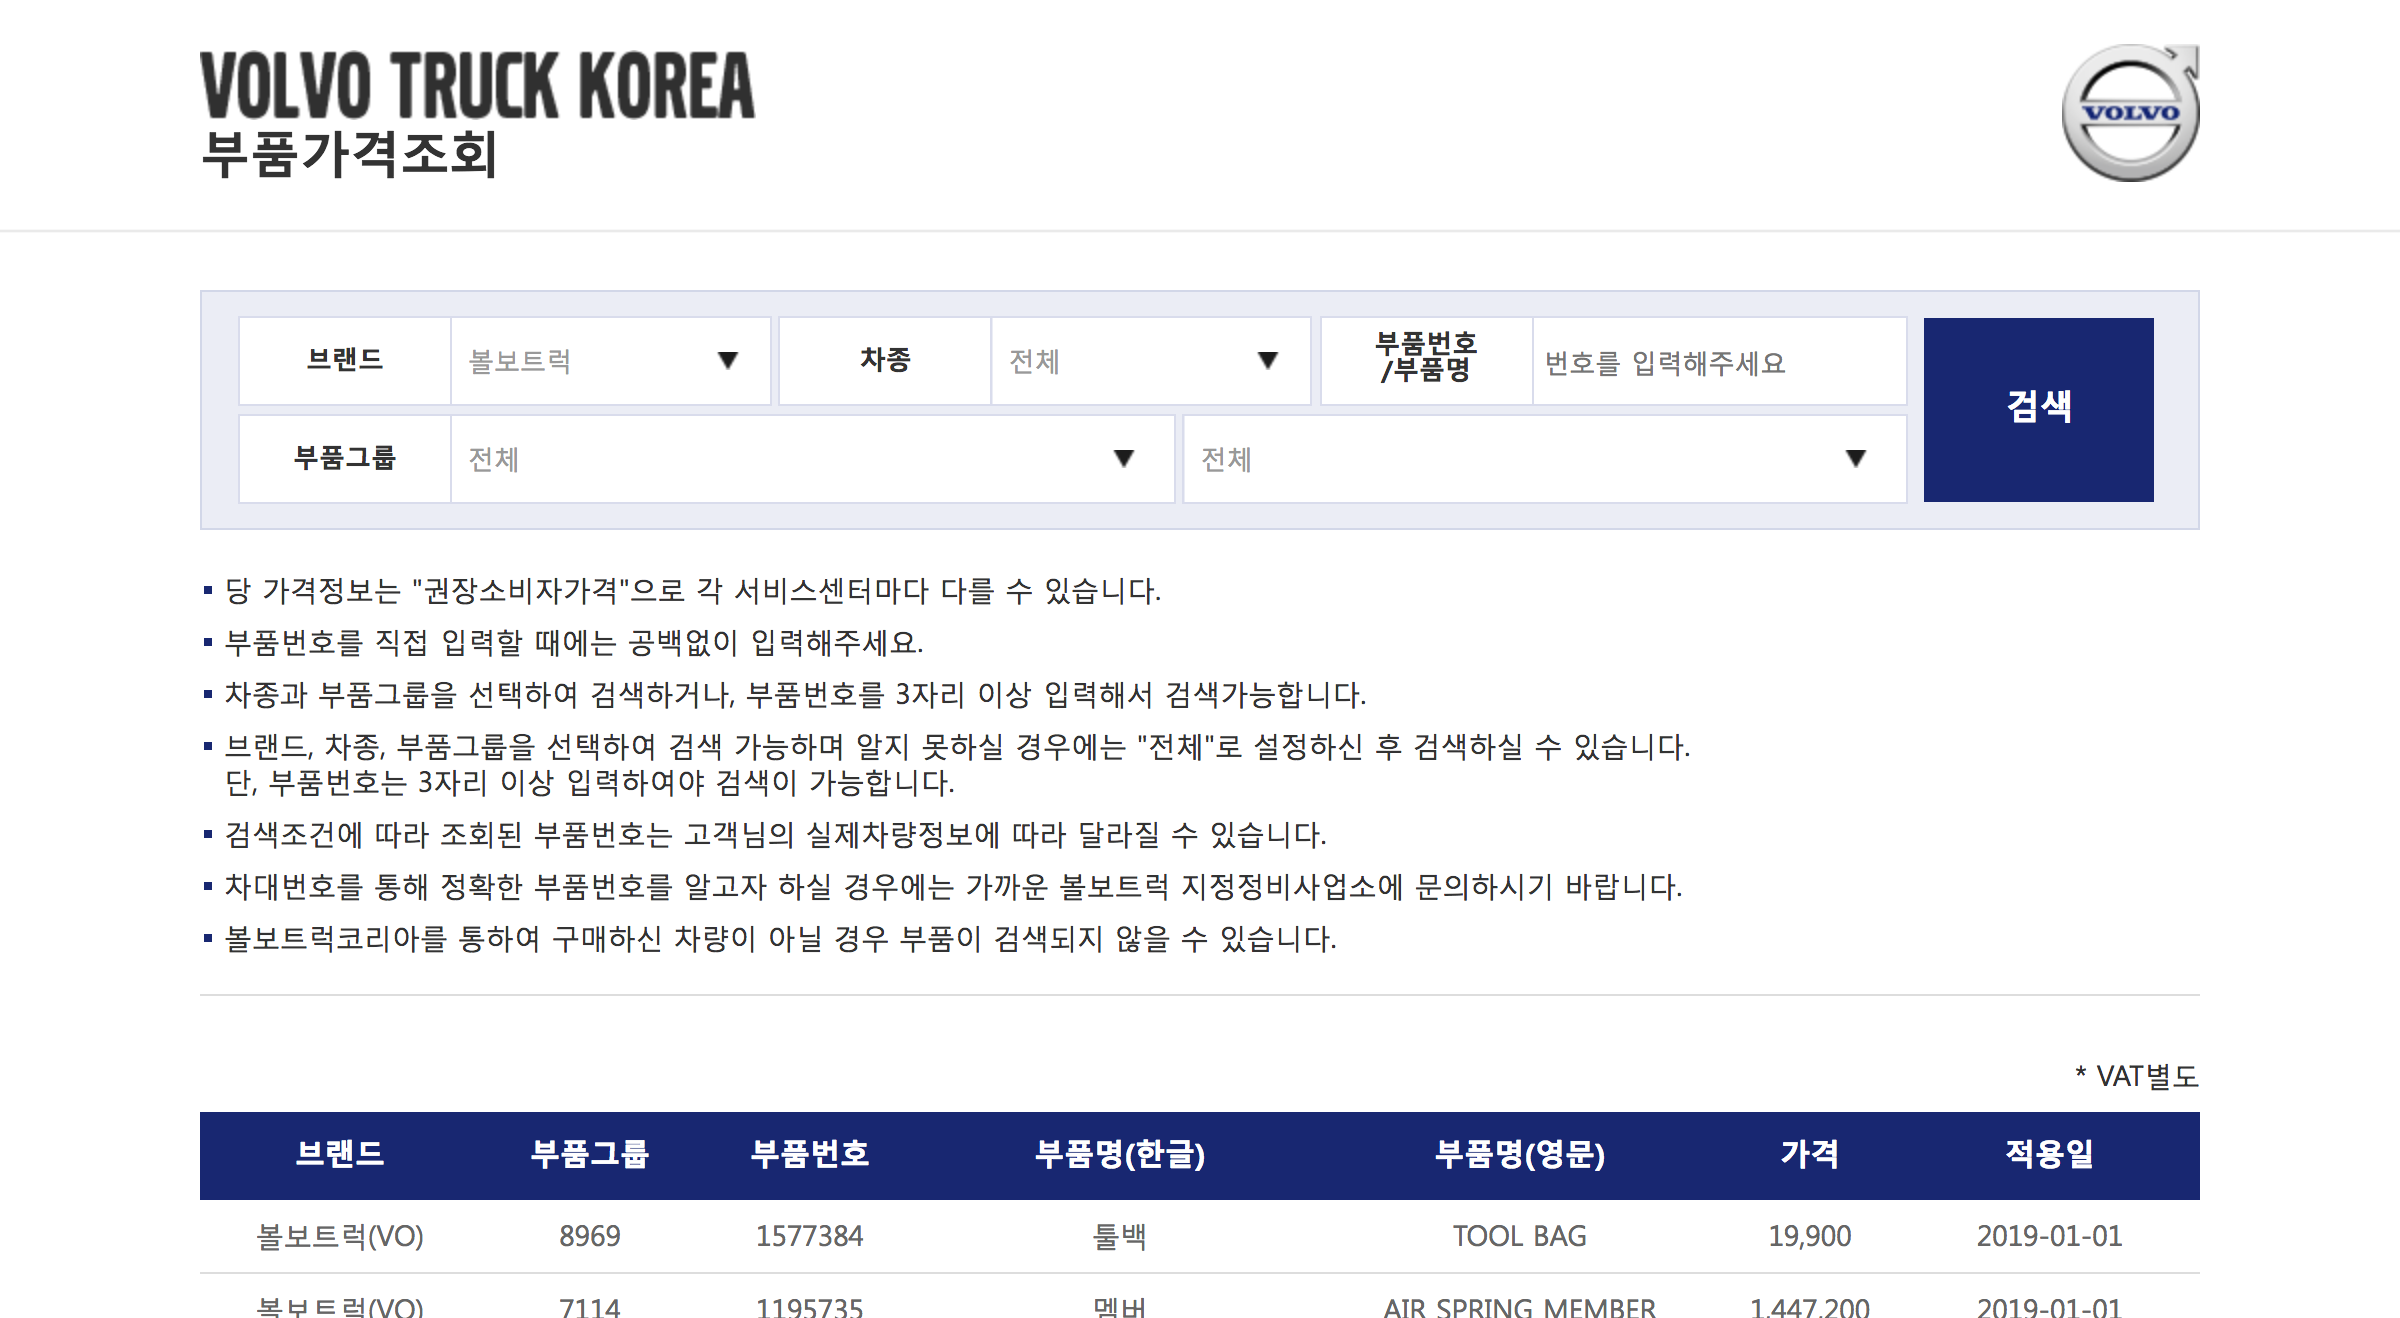

In [28]:
capture_img = './images/scania_site_1.png'
driver.save_screenshot(capture_img)
Image(capture_img)

In [29]:
html = driver.page_source
soup = bs(html, "lxml")
soup.title

<title>볼보 부품관리조회</title>

In [30]:
table_tag = soup.find('table', 'ta_list')
table_tag

<table class="ta_list">
<colgroup><col width="14%"/><col width="11%"/><col width="11%"/><col width="20%"/><col width="20%"/><col width="9%"/><col width="15%"/></colgroup>
<thead>
<tr>
<th>브랜드</th>
<th>부품그룹</th>
<th>부품번호</th>
<th>부품명(한글)</th>
<th>부품명(영문)</th>
<th>가격</th>
<th>적용일</th>
</tr>
</thead>
<tbody>
<tr>
<td>볼보트럭(VO)</td>
<td>8969</td>
<td>1577384</td>
<td>툴백</td>
<td>TOOL BAG</td>
<td> 19,900 </td>
<td>2019-01-01</td>
</tr>
<tr>
<td>볼보트럭(VO)</td>
<td>7114</td>
<td>1195735</td>
<td>멤버</td>
<td>AIR SPRING MEMBER</td>
<td> 1,447,200 </td>
<td>2019-01-01</td>
</tr>
<tr>
<td>볼보트럭(VO)</td>
<td>819</td>
<td>1159520</td>
<td>인포 뱅크</td>
<td>INFORM BANK</td>
<td> 571,900 </td>
<td>2019-01-01</td>
</tr>
<tr>
<td>볼보트럭(VO)</td>
<td>819</td>
<td>1159519</td>
<td>인포 뱅크</td>
<td>INFORM BANK RENAUL</td>
<td> 533,000 </td>
<td>2019-01-01</td>
</tr>
<tr>
<td>볼보트럭(VO)</td>
<td>818</td>
<td>1159504</td>
<td>인서트-오렌지</td>
<td>T-INSERT ORANGE</td>
<td> 400 </td>
<td>2019-01-01</td>
</tr>
<tr>
<td>볼보트럭(

In [32]:
tbody_tag = table_tag.find('tbody')
# tbody_tag

In [33]:
tr_tags = tbody_tag.find_all('tr')
tr_cnt = len(tr_tags)
tr_cnt

10

In [34]:
td_tags = tr_tags[0].find_all('td')
td_cnt = len(td_tags)
td_cnt

7

In [50]:
# 순번, ord_no
ord_no = ""

In [51]:
# 브랜드, brand
td_tags_1 = td_tags[0].get_text()
td_tags_1 = td_tags_1.strip()
td_tags_1

'볼보트럭(VO)'

In [52]:
# 부품그룹, device_grp
td_tags_2 = td_tags[1].get_text()
td_tags_2 = td_tags_2.strip()
td_tags_2

'8969'

In [53]:
# 부품번호, device_no
td_tags_3 = td_tags[2].get_text()
td_tags_3 = td_tags_3.strip()
td_tags_3

'1577384'

In [54]:
# 부품명(한글), device_nm_kr
td_tags_4 = td_tags[3].get_text()
td_tags_4 = td_tags_4.strip()
td_tags_4

'툴백'

In [55]:
# 부품명(영문), device_nm_en
td_tags_5 = td_tags[4].get_text()
td_tags_5 = td_tags_5.strip()
td_tags_5

'TOOL BAG'

In [56]:
# 가격(VAT별도), price
td_tags_6 = td_tags[5].get_text()
td_tags_6 = td_tags_6.replace(',', '')
td_tags_6 = td_tags_6.replace('\\', '')
td_tags_6 = td_tags_6.strip()
td_tags_6 = int(td_tags_6)
td_tags_6

19900

In [57]:
# 적용일, update_dt
td_tags_7 = td_tags[6].get_text()
td_tags_7 = td_tags_7.strip()
td_tags_7

'2019-01-01'

In [59]:
shift = -1
idx = 6+shift
idx

5

In [58]:
# 컬럼정보 : 순번, 브랜드, 부품그룹, 부품번호, 부품명(한글), 부품명(영문), 가격(VAT별도), 적용일
# Column : ord_no, brand, device_grp, device_no, device_nm_kr, device_nm_en, update_dt

In [62]:
def get_device_info(td_tags):
    '''
    Get informations of a device data
    Args:  
        td_tags : list, column data of a device in the table
    Returns: 
        device_info : list, parcing data
    '''    
    
    shift = -1
    
    device_info = list()
    td_tags_0 = ''  # td_tags[0].get_text().strip()    # 순번, ord_no
    td_tags_1 = td_tags[1+shift].get_text().strip()    # 브랜드, brand
    td_tags_2 = td_tags[2+shift].get_text().strip()    # 부품그룹, device_grp
    td_tags_3 = td_tags[3+shift].get_text().strip()    # 부품번호, device_no
    td_tags_4 = td_tags[4+shift].get_text().strip()    # 부품명(한글), device_nm_kr
    td_tags_5 = td_tags[5+shift].get_text().strip()    # 부품명(영문), device_nm_en
    td_tags_6 = td_tags[6+shift].get_text().strip()    # 가격(VAT별도), price
    td_tags_6 = td_tags_6.replace(',' , '')
    td_tags_6 = td_tags_6.replace('\\', '')
    td_tags_6 = td_tags_6.strip()
    td_tags_7 = td_tags[7+shift].get_text().strip()    # 적용일, update_dt
    
    # 숫자형
    # td_tags_0 = int(td_tags_0)
    td_tags_6 = int(td_tags_6)
    
    device_info.append(td_tags_0)
    device_info.append(td_tags_1)
    device_info.append(td_tags_2)
    device_info.append(td_tags_3)
    device_info.append(td_tags_4)
    device_info.append(td_tags_5)
    device_info.append(td_tags_6)
    device_info.append(td_tags_7)
    
    return device_info


In [63]:
device_info = get_device_info(td_tags)
device_info

['', '볼보트럭(VO)', '8969', '1577384', '툴백', 'TOOL BAG', 19900, '2019-01-01']

In [98]:
def is_number(value):
    chk_num = True
    num_chk_list = list('0123456789')
    
    for char in str(value):
        is_num = char in num_chk_list
        chk_num *= is_num
        if not is_num:
            break
        # print(char, is_num, chk_num)

#     if chk_num:
#         last_num = int(value)
#         print('입력한 숫자 :', last_num)
#     else:
#         print('입력한 값이 숫자가 아닙니다.')
        
    return chk_num

In [99]:
is_number('value')

0

In [103]:
def get_device_info(td_tags):
    '''
    Get informations of a device data
    Args:  
        td_tags : list, column data of a device in the table
    Returns: 
        device_info : dict, parcing data
    '''    
    
    shift = -1
    device_info = dict()
    td_tags_0 = ''  # td_tags[0].get_text().strip()    # 순번, ord_no
    td_tags_1 = td_tags[1+shift].get_text().strip()    # 브랜드, brand
    td_tags_2 = td_tags[2+shift].get_text().strip()    # 부품그룹, device_grp
    td_tags_3 = td_tags[3+shift].get_text().strip()    # 부품번호, device_no
    td_tags_4 = td_tags[4+shift].get_text().strip()    # 부품명(한글), device_nm_kr
    td_tags_5 = td_tags[5+shift].get_text().strip()    # 부품명(영문), device_nm_en
    td_tags_6 = td_tags[6+shift].get_text().strip()    # 가격(VAT별도), price
    td_tags_6 = td_tags_6.replace(',' , '')
    td_tags_6 = td_tags_6.replace('\\', '')
    td_tags_6 = td_tags_6.strip()
    td_tags_7 = td_tags[7+shift].get_text().strip()    # 적용일, update_dt
    
    # 숫자형
    # td_tags_0 = int(td_tags_0)
    # td_tags_6 = int(is_number(td_tags_6))
    
    
    device_info['ord_no'      ] = td_tags_0
    device_info['brand'       ] = td_tags_1
    device_info['device_grp'  ] = td_tags_2
    device_info['device_no'   ] = td_tags_3
    device_info['device_nm_kr'] = td_tags_4
    device_info['device_nm_en'] = td_tags_5
    device_info['price'       ] = td_tags_6
    device_info['update_dt'   ] = td_tags_7
    
    return device_info


In [66]:
device_info = get_device_info(td_tags)
device_info

{'ord_no': '',
 'brand': '볼보트럭(VO)',
 'device_grp': '8969',
 'device_no': '1577384',
 'device_nm_kr': '툴백',
 'device_nm_en': 'TOOL BAG',
 'price': 19900,
 'update_dt': '2019-01-01'}

### <font color='brown'>Step3. Device List 가져오기</font>

In [67]:
tr_tags = tbody_tag.find_all('tr')
tr_cnt = len(tr_tags)
tr_cnt

10

In [68]:
td_tags = tr_tags[0].find_all('td')
td_cnt = len(td_tags)
td_cnt

7

In [69]:
def get_device_list(tr_tags):
    '''
    Get informations of a device data
    Args:  
        tr_tags : list, device data list of a navigation page 
    Returns: 
        device_list : list[of dict], parcing data by page
    '''    
    
    device_list = list()
    
    tr_cnt = len(tr_tags)
    if tr_cnt == 0:
        return 
    
    for i in range(tr_cnt):
        td_tags = tr_tags[i].find_all('td')
        device_info = get_device_info(td_tags)
        device_list.append(device_info)
    
    return device_list


In [70]:
device_list = get_device_list(tr_tags)
device_list

[{'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '8969',
  'device_no': '1577384',
  'device_nm_kr': '툴백',
  'device_nm_en': 'TOOL BAG',
  'price': 19900,
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '7114',
  'device_no': '1195735',
  'device_nm_kr': '멤버',
  'device_nm_en': 'AIR SPRING MEMBER',
  'price': 1447200,
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '819',
  'device_no': '1159520',
  'device_nm_kr': '인포 뱅크',
  'device_nm_en': 'INFORM BANK',
  'price': 571900,
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '819',
  'device_no': '1159519',
  'device_nm_kr': '인포 뱅크',
  'device_nm_en': 'INFORM BANK RENAUL',
  'price': 533000,
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '818',
  'device_no': '1159504',
  'device_nm_kr': '인서트-오렌지',
  'device_nm_en': 'T-INSERT ORANGE',
  'price': 400,
  'update_dt': '2019-01-01'},
 {'ord

### <font color='brown'>Step4. 페이지별 Device List 가져오기</font>

In [95]:
def is_number(value):
    chk_num = True
    num_chk_list = list('0123456789')
    
    for char in str(value):
        is_num = char in num_chk_list
        chk_num *= is_num
        if not is_num:
            break
        # print(char, is_num, chk_num)

    if chk_num:
        last_num = int(value)
        print('입력한 숫자 :', last_num)
    else:
        print('입력한 값이 숫자가 아닙니다.')
        
    return chk_num

In [97]:
value = '#N/A'
is_number(value)


입력한 값이 숫자가 아닙니다.


0

In [71]:
def get_device_list_by_page(brand_cd, start_pg, end_pg):
    '''
    Get informations of page ranges
    Args:  
        brand_cd : str, brand code of volvo     cf. 1:볼보트럭, 2:유디트럭  
        start_pg : int, start page of gathering data 
        end_pg   : int, end page of gathering data
    Returns: 
        device_list_total : list[of dict], parcing data of page ranges
    '''    
    
    device_list_total = list()
    
    page_url = 'http://parts.volvotruck.kr/main.html?schWord=&schBrand={}&schGroup1=&schGroup2=&schCarType=&page={}'
   
    for navi_page in range(start_pg, end_pg+1):
        sch_brand  = brand_cd
        param_page = navi_page
        driver.get(page_url.format(sch_brand, param_page))
        
        time.sleep(1)
        html = driver.page_source
        soup = bs(html, "lxml")
        
        table_tag = soup.find('table', 'ta_list')
        tbody_tag = table_tag.find('tbody')
        tr_tags = tbody_tag.find_all('tr')
        tr_cnt = len(tr_tags)
        
        if tr_cnt > 0:
            device_list = list()
        else:
            break
        
        device_list = get_device_list(tr_tags)
        
        device_list_total.extend(device_list)
    
    return device_list_total


In [107]:
schBrand = '1'      # 1:볼보트럭, 2:유디트럭  
device_list_total = get_device_list_by_page(schBrand, 1, 1)
len(device_list_total)

10

In [108]:
device_list_total

[{'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '8969',
  'device_no': '1577384',
  'device_nm_kr': '툴백',
  'device_nm_en': 'TOOL BAG',
  'price': '19900',
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '7114',
  'device_no': '1195735',
  'device_nm_kr': '멤버',
  'device_nm_en': 'AIR SPRING MEMBER',
  'price': '1447200',
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '819',
  'device_no': '1159520',
  'device_nm_kr': '인포 뱅크',
  'device_nm_en': 'INFORM BANK',
  'price': '571900',
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '819',
  'device_no': '1159519',
  'device_nm_kr': '인포 뱅크',
  'device_nm_en': 'INFORM BANK RENAUL',
  'price': '533000',
  'update_dt': '2019-01-01'},
 {'ord_no': '',
  'brand': '볼보트럭(VO)',
  'device_grp': '818',
  'device_no': '1159504',
  'device_nm_kr': '인서트-오렌지',
  'device_nm_en': 'T-INSERT ORANGE',
  'price': '400',
  'update_dt': '2019-01-01

### <font color='brown'>Step5. 페이지별 Device List 저장하기</font>

In [42]:
# 컬럼정보 : 순번, 브랜드, 부품그룹, 부품번호, 부품명(한글), 부품명(영문), 가격(VAT별도)
# Column : ord_no, brand, device_grp, device_no, device_nm_kr, device_nm_en, price

In [110]:
import csv

csv_columns = [ 'ord_no', 'brand', 'device_grp', 'device_no', 'device_nm_kr', 'device_nm_en', 'price', 'update_dt' ]
dict_data = [
     {'ord_no': '',
      'brand': '볼보트럭(VO)',
      'device_grp': '8969',
      'device_no': '1577384',
      'device_nm_kr': '툴백',
      'device_nm_en': 'TOOL BAG',
      'price': '19900',
      'update_dt': '2019-01-01'},
     {'ord_no': '',
      'brand': '볼보트럭(VO)',
      'device_grp': '7114',
      'device_no': '1195735',
      'device_nm_kr': '멤버',
      'device_nm_en': 'AIR SPRING MEMBER',
      'price': '1447200',
      'update_dt': '2019-01-01'},
     {'ord_no': '',
      'brand': '볼보트럭(VO)',
      'device_grp': '819',
      'device_no': '1159520',
      'device_nm_kr': '인포 뱅크',
      'device_nm_en': 'INFORM BANK',
      'price': '571900',
      'update_dt': '2019-01-01'},
]
# dict_data = device_list_total

csv_file = 'data/volvo_test.csv'
try:
    with open(csv_file, 'w', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow(data)
except IOError:
    print("I/O error") 
    

In [111]:
df = pd.read_csv(csv_file)
df.head()

,ord_no,brand,device_grp,device_no,device_nm_kr,device_nm_en,price,update_dt
0,NaN,볼보트럭(VO),8969,1577384,툴백,TOOL BAG,19900,2019-01-01
1,NaN,볼보트럭(VO),7114,1195735,멤버,AIR SPRING MEMBER,1447200,2019-01-01
2,NaN,볼보트럭(VO),819,1159520,인포 뱅크,INFORM BANK,571900,2019-01-01


In [112]:
dirname='data'
filename='volvo_data.csv'

In [113]:
if not dirname.endswith('/'):
    dirname += '/'
    
if not filename.endswith('.csv'):
    filename += '.csv'

csv_file = dirname + filename
csv_file

'data/volvo_data.csv'

In [116]:
def save_dict_to_csv(device_list_total, dirname='data', filename='crawling_data.csv'):
    '''
    Save crawling data to csv file
    Args:  
        device_list_total : list[of dict], parcing data of page ranges
        dirname  : str, folder name
        filename : str, file name 
    Returns: 
        csv_file : str, full path of saved files
        ret_msg  : str, result message
    '''    
    
    csv_columns = [ 'ord_no', 'brand', 'device_grp', 'device_no', 'device_nm_kr', 'device_nm_en', 'price', 'update_dt' ]
    dict_data = device_list_total

    if not dirname.endswith('/'):
        dirname += '/'

    if not filename.endswith('.csv'):
        filename += '.csv'

    csv_file = dirname + filename
    ret_msg = '성공적으로 저장되었습니다! '

    try:
        with open(csv_file, 'w', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            writer.writeheader()
            for data in dict_data:
                writer.writerow(data)
    except IOError:
        print("I/O error") 

    return csv_file, ret_msg


In [117]:
dirname='data'
filename='volvo_data.csv'
csv_file, msg = save_dict_to_csv(device_list_total, dirname, filename)
print(msg)
print('File :', csv_file)

성공적으로 저장되었습니다! 
File : data/volvo_data.csv


In [118]:
# check saved files
df_scania = pd.read_csv(csv_file)
df_scania.tail(10)

,ord_no,brand,device_grp,device_no,device_nm_kr,device_nm_en,price,update_dt
0,NaN,볼보트럭(VO),8969,1577384,툴백,TOOL BAG,19900,2019-01-01
1,NaN,볼보트럭(VO),7114,1195735,멤버,AIR SPRING MEMBER,1447200,2019-01-01
2,NaN,볼보트럭(VO),819,1159520,인포 뱅크,INFORM BANK,571900,2019-01-01
3,NaN,볼보트럭(VO),819,1159519,인포 뱅크,INFORM BANK RENAUL,533000,2019-01-01
4,NaN,볼보트럭(VO),818,1159504,인서트-오렌지,T-INSERT ORANGE,400,2019-01-01
5,NaN,볼보트럭(VO),818,1159503,인서트-그린,T-INSERT GREEN,400,2019-01-01
6,NaN,볼보트럭(VO),818,1159501,인서트-라일락,T-INSERT LILAC,400,2019-01-01
7,NaN,볼보트럭(VO),818,1159499,세퍼레이터,SEPARATOR,1000,2019-01-01
8,NaN,볼보트럭(VO),818,1159498,휴지통,BIN-BOX,4600,2019-01-01
9,NaN,볼보트럭(VO),810,1159495,플레이트,PLATE-REGISTER,678500,2019-01-01


### <font color='red'>[Solution] 모듈기반 Scania 데이터 크롤링</font>

In [1]:
from module import bl_dc_volvo as bpc
from IPython.display import Image 
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

In [3]:
blCrawl = bpc.BlVolvo()
msg = blCrawl.chk_module('Volvo Data Crawling !!')
msg

'Volvo Data Crawling !!'

In [4]:
# get webdriver instance
driver = blCrawl.get_driver()

In [4]:
key_brand='SCANIA'  # SCANIA or HINO

In [5]:
result_cnt, last_page = blScania.get_total_count(driver, brand=key_brand)

검색된 총 데이터수는 24525건이며, 마지막 페이지는 1635입니다.


In [6]:
device_list_total = blScania.get_device_list_by_page(1625, 1635, driver, key_brand)
print('브랜드 {} 데이터 {}건이 크롤링 되었습니다!'.format(key_brand, len(device_list_total)))


브랜드 SCANIA 데이터 165건이 크롤링 되었습니다!


In [7]:
dirname  = 'data'
filename = key_brand + '_' + str(len(device_list_total))
csv_file, msg = blScania.save_dict_to_csv(device_list_total, dirname, filename)
print(msg)
print('File :', csv_file)

성공적으로 저장되었습니다! 
File : data/SCANIA_165.csv


In [8]:
df_scania = pd.read_csv(csv_file)
df_scania.tail(10)

,ord_no,brand,device_grp,device_no,device_nm_kr,device_nm_en,price
155,24516,SCANIA,13. 조임장치및가스켓,1111373,반조나사,BANJOSCREW,15800
156,24517,SCANIA,13. 조임장치및가스켓,1340912,니쁠,NIPPLE,22500
157,24518,SCANIA,10. 캐빈관련,1373058,커버,COVER,7200
158,24519,SCANIA,5. 동력전달장치,1342311,리엑터,REACTOR,1180000
159,24520,SCANIA,5. 동력전달장치,1342307,리액터,REACTOR,1310000
160,24521,SCANIA,7. 샤시관련,8400101,리페어 키트 (Al용 가드레일),REPAIR KIT,18900
161,24522,SCANIA,13. 조임장치및가스켓,1516474,가스켓,GASKET,10200
162,24523,SCANIA,10. 캐빈관련,1428394,루프등 리페어 키트,REPAIR KIT,77000
163,24524,SCANIA,11. 전기전자,1513321,"콘트롤 유니트(ABS,EBS)",TEAILER COTROL UNIT,298000
164,24525,SCANIA,5. 동력전달장치,1375404,커플 하프,COUPL HALF,960000


### <font color='red'> [TIP] UTF-8 한글 CSV파일 Office에서 제대로 읽기 </font>
> https://www.lesstif.com/pages/viewpage.action?pageId=54952504
- 엑셀을 실행하고 데이타 → 텍스트 를 선택합니다.
- 가져올 파일을 선택하고 확인을 클릭합니다.
- 콤보 박스에서 적절한 코드 타입이 선택됐는지 확인합니다.

### <font color='red'> [Appendix] Module Source Code </font>
> module / bl_dc_scania.py

<hr>
``` python

from selenium import webdriver as wd
from bs4 import BeautifulSoup as bs

from selenium.webdriver.common.by import By
from tqdm import tqdm_notebook

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from IPython.display import Image

import numpy as np
import pandas as pd
import platform
import time
import sys
import csv

class BlScania:

    def get_driver(self):
        # 드라이브 로드
        if platform.system() == 'Darwin':    # MacOS
            driver = wd.Chrome(executable_path='./driver/chromedriver')      
        elif platform.system() == 'Windows': # Windows
            driver = wd.Chrome(executable_path='./driver/chromedriver.exe')    
        else:
            print("It's unknown system. Hangul fonts are not supported!")
        
        return driver
       

        
    def get_total_count(self, driver, brand='SCANIA'):
        '''
        Get a total count of data by brand
        Args:  
            driver : obj, web driver instance
            brand  : str, value of brand code    
                     cf. SCANIA or HINO
        Returns: 
            result_cnt : int, total data count
            last_page  : int, page number
        '''
        
        target_url = 'http://221.143.43.214/'
        brend_keyword = brand    # SCANIA or HINO

        driver.get(target_url)

        html = driver.page_source
        soup = bs(html, "lxml")

        # 검색 브랜드 선택
        driver.find_element_by_css_selector('#brend').send_keys(brend_keyword)

        # 검색 버튼 클릭
        search_btn = '#con2 > div > div.search2 > form > fieldset > table > tbody > tr:nth-child(3) > td > button'
        driver.find_element_by_css_selector(search_btn).click()

        html = driver.page_source
        soup = bs(html, "lxml")

        result_cnt = soup.find('span', 'fcop4').get_text()
        result_cnt = int(result_cnt)

        last_page = int(result_cnt / 15)

        print('검색된 총 데이터수는 {}건이며, 마지막 페이지는 {}입니다.'.format(result_cnt, last_page))

        return result_cnt, last_page

       
    
    def get_device_info(self, td_tags):
        '''
        Get informations of a device data
        Args:  
            td_tags : list, column data of a device in the table
        Returns: 
            device_info : dict, parcing data
        '''    
    
        device_info = dict()
        td_tags_0 = td_tags[0].get_text().strip()    # 순번, ord_no
        td_tags_1 = td_tags[1].get_text().strip()    # 브랜드, brand
        td_tags_2 = td_tags[2].get_text().strip()    # 부품그룹, device_grp
        td_tags_3 = td_tags[3].get_text().strip()    # 부품번호, device_no
        td_tags_4 = td_tags[4].get_text().strip()    # 부품명(한글), device_nm_kr
        td_tags_5 = td_tags[5].get_text().strip()    # 부품명(영문), device_nm_en
        td_tags_6 = td_tags[6].get_text().strip()    # 가격(VAT별도), price
        td_tags_6 = td_tags_6.replace(',' , '')
        td_tags_6 = td_tags_6.replace('\\', '')
        td_tags_6 = td_tags_6.strip()

        # 숫자형
        td_tags_0 = int(td_tags_0)
        td_tags_6 = int(td_tags_6)


        device_info['ord_no'      ] = td_tags_0
        device_info['brand'       ] = td_tags_1
        device_info['device_grp'  ] = td_tags_2
        device_info['device_no'   ] = td_tags_3
        device_info['device_nm_kr'] = td_tags_4
        device_info['device_nm_en'] = td_tags_5
        device_info['price'       ] = td_tags_6

        return device_info

    

    def get_device_list(self, tr_tags):
        '''
        Get informations of a device data
        Args:  
            tr_tags : list, device data list of a navigation page 
        Returns: 
            device_list : list[of dict], parcing data by page
        '''    
        
        device_list = list()

        tr_cnt = len(tr_tags)
        if tr_cnt == 0:
            return 

        for i in range(tr_cnt):
            td_tags = tr_tags[i].find_all('td')
            device_info = self.get_device_info(td_tags)
            device_list.append(device_info)

        return device_list

    

    def get_device_list_by_page(self, start_pg, end_pg, driver, key_brand='SCANIA'):
        '''
        Get informations of page ranges
        Args:  
            start_pg : int, start page of gathering data 
            end_pg   : int, end page of gathering data
        Returns: 
            device_list_total : list[of dict], parcing data of page ranges
        '''    

        device_list_total = list()

        page_url = 'http://221.143.43.214/index.html?page={}&key=Y&brend={}&series2=&&series3=&part_no=&type1=&type2='

        for navi_page in tqdm_notebook(range(start_pg, end_pg+1)):
            param_page  = navi_page
            # param_brend = 'SCANIA'
            param_brend = key_brand
            driver.get(page_url.format(param_page, param_brend))

            time.sleep(1)
            html = driver.page_source
            soup = bs(html, "lxml")

            table_tag = soup.find('table', 'tbl2')
            tbody_tag = table_tag.find('tbody')
            tr_tags = tbody_tag.find_all('tr')
            tr_cnt = len(tr_tags)

            if tr_cnt > 0:
                device_list = list()
            else:
                break

            device_list = self.get_device_list(tr_tags)

            device_list_total.extend(device_list)

        return device_list_total

    

    def save_dict_to_csv(self, device_list_total, dirname='data', filename='scania_data.csv'):
        '''
        Save crawling data to csv file
        Args:  
            device_list_total : list[of dict], parcing data of page ranges
            dirname  : str, folder name
            filename : str, file name 
        Returns: 
            csv_file : str, full path of saved files
            ret_msg  : str, result message
        '''    
        
        csv_columns = [ 'ord_no', 'brand', 'device_grp', 'device_no', 'device_nm_kr', 'device_nm_en', 'price' ]
        dict_data = device_list_total

        if not dirname.endswith('/'):
            dirname += '/'

        if not filename.endswith('.csv'):
            filename += '.csv'

        csv_file = dirname + filename
        ret_msg = '성공적으로 저장되었습니다! '
        
        try:
            with open(csv_file, 'w', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                writer.writeheader()
                for data in dict_data:
                    writer.writerow(data)
        except IOError:
            print("I/O error") 
            
        return csv_file, ret_msg

    

    def chk_module(self, msg):
        if msg is None:
            msg = 'No Param'
            
        return msg
    
```
<hr>

<hr>
<marquee><font size=3 color='brown'>The BigpyCraft find the information to design valuable society with Technology & Craft.</font></marquee>
<div align='right'><font size=2 color='gray'> &lt; The End &gt; </font></div>